In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import r2_score ,mean_absolute_error ,mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor 
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import re

In [2]:
df = pd.read_csv('laptop_price.csv').drop(columns = ['Unnamed: 0.1', 'Unnamed: 0'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              893 non-null    object 
 1   name               893 non-null    object 
 2   price              893 non-null    int64  
 3   spec_rating        893 non-null    float64
 4   processor          893 non-null    object 
 5   CPU                893 non-null    object 
 6   Ram                893 non-null    object 
 7   Ram_type           893 non-null    object 
 8   ROM                893 non-null    object 
 9   ROM_type           893 non-null    object 
 10  GPU                893 non-null    object 
 11  display_size       893 non-null    float64
 12  resolution_width   893 non-null    float64
 13  resolution_height  893 non-null    float64
 14  OS                 893 non-null    object 
 15  warranty           893 non-null    int64  
dtypes: float64(4), int64(2), o

In [4]:
df = df.drop(columns = 'name')

## Классическая модель линейной регрессии невозможна из-за отсутствия ярко выраженной корреляции между таргетом и придикторами
## There's no posibility to use classic linear regression model because of absence of strong linear correlation between target and predictors

C:\Users\cours\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


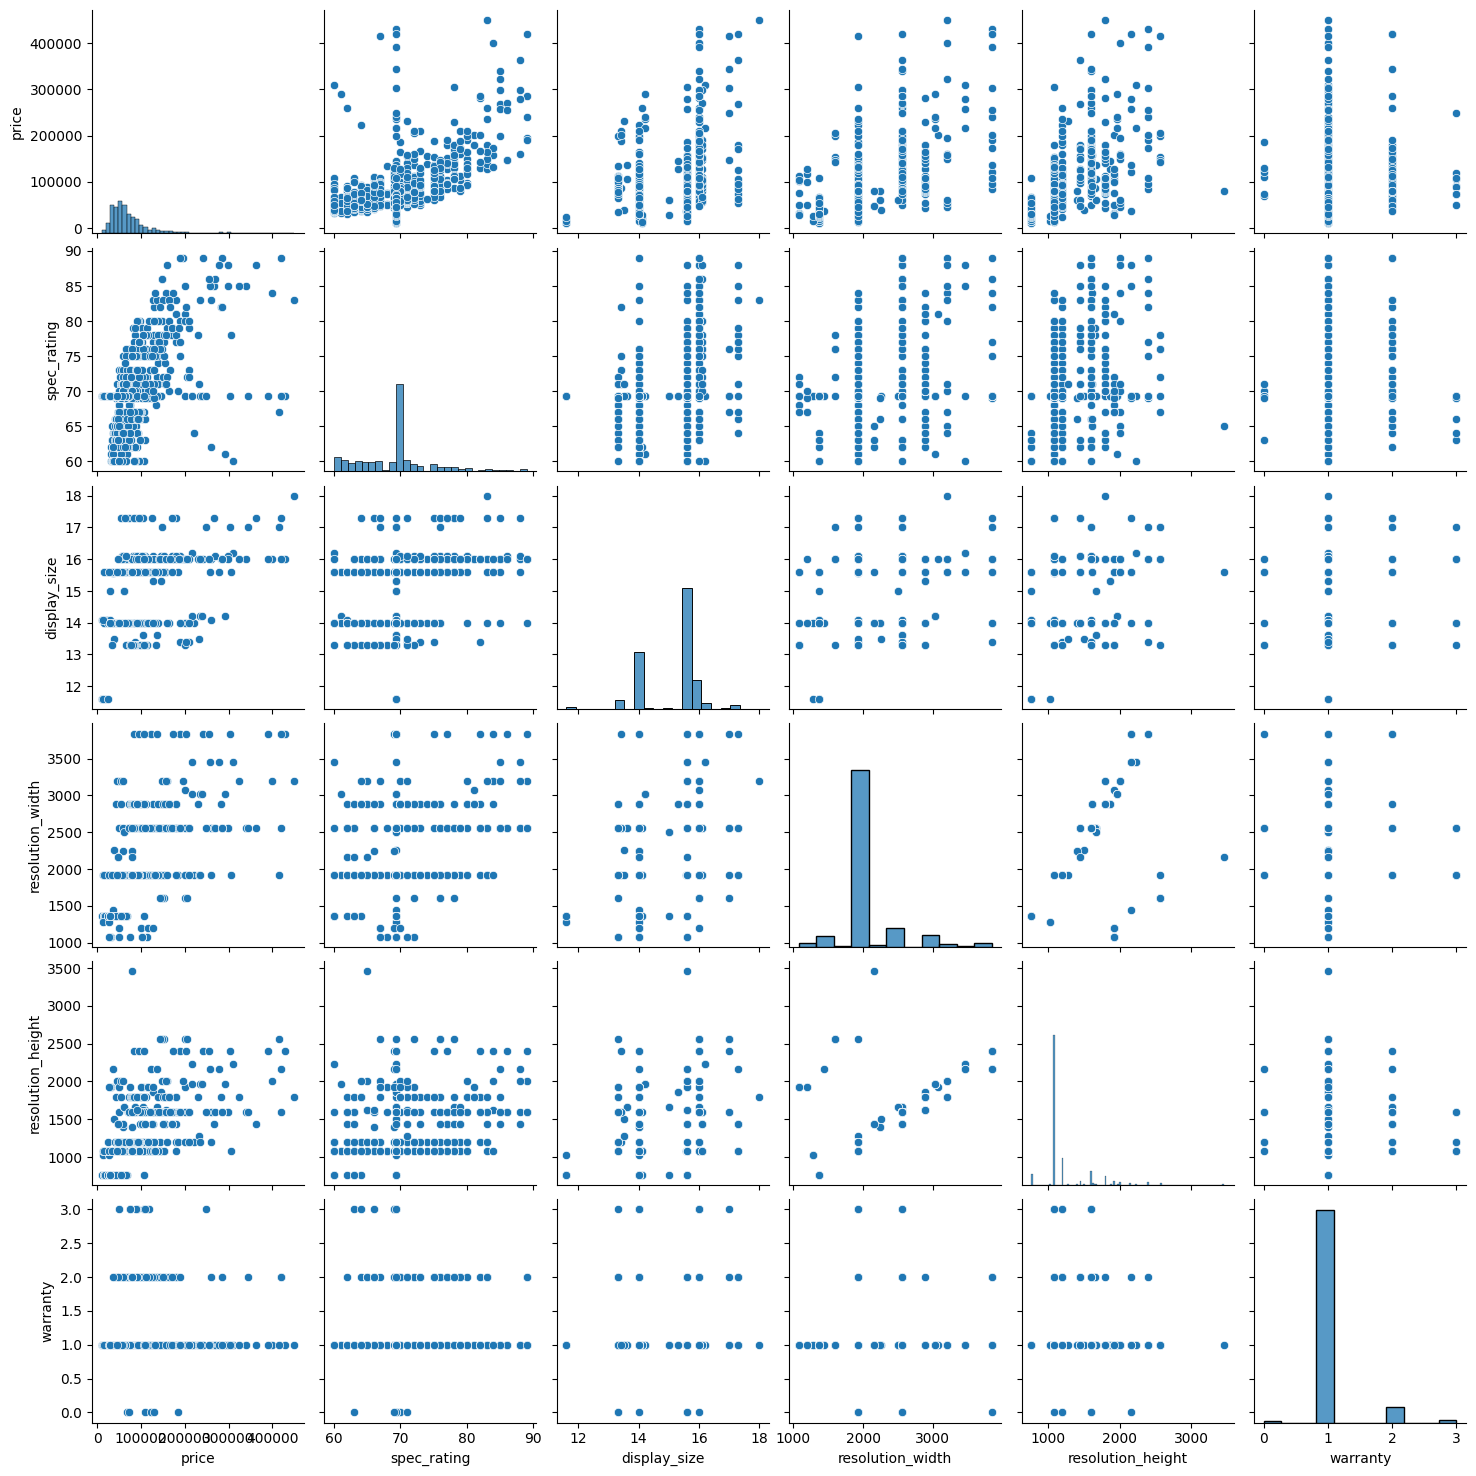

In [5]:
sns.pairplot(df.select_dtypes(exclude = 'object'))

In [6]:
df.head()

,brand,price,spec_rating,processor,CPU,Ram,Ram_type,ROM,ROM_type,GPU,display_size,resolution_width,resolution_height,OS,warranty
0,HP,49900,73.000000,5th Gen AMD Ryzen 5 5600H,"Hexa Core, 12 Threads",8GB,DDR4,512GB,SSD,4GB AMD Radeon RX 6500M,15.6,1920.0,1080.0,Windows 11 OS,1
1,HP,39900,60.000000,12th Gen Intel Core i3 1215U,"Hexa Core (2P + 4E), 8 Threads",8GB,DDR4,512GB,SSD,Intel UHD Graphics,15.6,1920.0,1080.0,Windows 11 OS,1
2,Acer,26990,69.323529,11th Gen Intel Core i3 1115G4,"Dual Core, 4 Threads",8GB,DDR4,512GB,SSD,Intel Iris Xe Graphics,14.0,1920.0,1080.0,Windows 11 OS,1
3,Lenovo,59729,66.000000,12th Gen Intel Core i5 1240P,"12 Cores (4P + 8E), 16 Threads",16GB,LPDDR5,512GB,SSD,Intel Integrated Iris Xe,14.0,2240.0,1400.0,Windows 11 OS,1
4,Apple,69990,69.323529,Apple M1,Octa Core (4P + 4E),8GB,DDR4,256GB,SSD,Apple M1 Integrated Graphics,13.3,2560.0,1600.0,Mac OS,1


In [7]:
# Exctracting processor properties| Выделяем свойства процессора
df['processor'] = df['processor'].apply(lambda x: re.sub('  ', ' ', x))

In [8]:
# Most values look similar, so there is a possibility to use regular expressions|
# Большинство, значений в колонке процессор выглядят одинаково, значит можно использовать регулярные выражения
df['processor'].unique()

array(['5th Gen AMD Ryzen 5 5600H', '12th Gen Intel Core i3 1215U',
       '11th Gen Intel Core i3 1115G4', '12th Gen Intel Core i5 1240P',
       'Apple M1', '13th Gen Intel Core i5 13420H',
       '12th Gen Intel Core i5 12500H', '12th Gen Intel Core i7 1255U',
       'Intel Celeron N4020', 'MediaTek MTK8788',
       '7th Gen AMD Ryzen 3 7320U', '11th Gen Intel Core i5 11400H ',
       '13th Gen Intel Core i9 13900H', '12th Gen Intel Core i5 12450H',
       '11th Gen Intel Core i5 11300H', 'Apple M2',
       '11th Gen Intel Core i5 1135G7 ', '5th Gen AMD Ryzen 7 5800H',
       '5th Gen AMD Ryzen 5 5500U', '3rd Gen AMD Athlon 3050U',
       'Intel Core i3 N305', '13th Gen Intel Core i7 1355U',
       '6th Gen AMD Ryzen 5 6600H', '13th Gen Intel Core i9 13900HX',
       '12th Gen Intel Core i7 12650H', '13th Gen Intel Core i5 1340P',
       '12th Gen Intel Core i5 1235U ', '13th Gen Intel Core i5 13450HX',
       '13th Gen Intel Core i9 13980HX', '11th Gen Intel Core i5 1135G7',
      

In [9]:
# A dict for implementing values in cells without generation number|Слоаврь для подставления значений в поколения, где нет номера
d = {}
for i, j in enumerate(df[~df['processor'].str.contains('th')]['processor'].apply(lambda x: x.split(' ')[0]).unique()):
    d[j] = str(i*1000)

In [10]:
# Extract processor generation|Извлечение поколения процессора
df['proc_gen'] = df['processor'].apply(lambda x: x.split(' ')[0]
                                         if 'th' in x else int(d[x.split(' ')[0]]))

# Extract processor type|Извлечение типа процессора
df['proc_type'] = df['processor'].apply(lambda x:  x if(len(x.split(' '))) == 1 else x.split(' ')[-2])

# Extract processor name|Извлечение назавния процессора
df['proc_name'] = df['processor'].apply(lambda x: x.split(' ')[0] if(len(x.split(' '))) < 5 else x.split(' ')[2])

# Extract processor number|Извлечение номера процессора
df['proc_num'] = df['processor'].apply(lambda x: re.sub(r'[a-zA-Z]', '', x.split(' ')[-1]))

# Extract gpu maker|Извлечение производтеля ГПУ
df['gpu_brand'] = df['GPU'].apply(lambda x: 'AMD' if 'AMD' in x else('Intel' if 'Intel' in x
                                                  else('NVIDIA' if 'Nvidia' in x or 'NVIDIA' in x
                                                      else('Apple' if 'Apple' in x else 'other'))))

# Extract number of threads|Извлечение количества ядер
df['cpu_threads'] = df['CPU'].apply(lambda x: [i.strip() if 'Threads' in i and 'Threads' in x else 'other' for i in x.split(',')][-1])

# Extract RAM memory|Извлечение RAM-памяти
df['Ram'] = df['Ram'].str.replace('GB', '')

# Extract ROM memory|Извлечение ROM-памяти
df['ROM'] = df['ROM'].str.replace('GB', '').str.replace('TB', '').apply(lambda x: int(x) if int(x) > 2 else int(x)*1024)

In [11]:
# Extract OS brand|Извлечение ОС
df['OS'] = df['OS'].apply(lambda x: x.split(' ')[0])

In [12]:
# Square of display|Площадь экран
df['square'] = df['resolution_width']*df['resolution_height']

In [13]:
df.columns

Index(['brand', 'price', 'spec_rating', 'processor', 'CPU', 'Ram', 'Ram_type',
       'ROM', 'ROM_type', 'GPU', 'display_size', 'resolution_width',
       'resolution_height', 'OS', 'warranty', 'proc_gen', 'proc_type',
       'proc_name', 'proc_num', 'gpu_brand', 'cpu_threads', 'square'],
      dtype='object')

In [14]:
# Choose necessary columns|Выбор необходимых колонок
df = df[['brand', 'price', 'spec_rating', 'Ram_type', 'ROM', 'ROM_type', 'square',
         'OS', 'warranty', 'proc_gen', 'proc_type','proc_name', 'proc_num', 'gpu_brand', 'cpu_threads']]
df.head()

,brand,price,spec_rating,Ram_type,ROM,ROM_type,square,OS,warranty,proc_gen,proc_type,proc_name,proc_num,gpu_brand,cpu_threads
0,HP,49900,73.000000,DDR4,512,SSD,2073600.0,Windows,1,5th,5,AMD,5600,AMD,12 Threads
1,HP,39900,60.000000,DDR4,512,SSD,2073600.0,Windows,1,12th,i3,Intel,1215,Intel,8 Threads
2,Acer,26990,69.323529,DDR4,512,SSD,2073600.0,Windows,1,11th,i3,Intel,11154,Intel,4 Threads
3,Lenovo,59729,66.000000,LPDDR5,512,SSD,3136000.0,Windows,1,12th,i5,Intel,1240,Intel,16 Threads
4,Apple,69990,69.323529,DDR4,256,SSD,4096000.0,Mac,1,0,Apple,Apple,1,Apple,other


<Axes: >

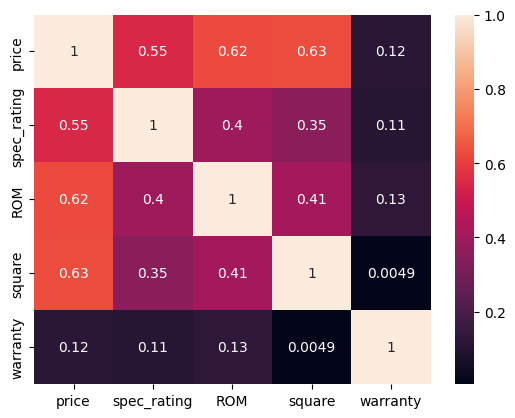

In [15]:
# There's no high correlation between predictors|Меджу предикторами нет высокой корреляции
sns.heatmap(df.select_dtypes(exclude='object').corr(), annot=True)

In [16]:
# Numeric columns|Числовые колонки
df_num = df.select_dtypes(exclude = 'object').drop(columns = ['price'])

df_num = pd.DataFrame(StandardScaler().fit_transform(df_num), columns = df_num.columns)

In [17]:
# Categorical features; for columns with a big number of values|Категориальные фичи; лэйбл-энкодер для колонок с большим количеством значений
df_cat = df.select_dtypes(include = 'object').drop(columns = ['brand', 'proc_name', 'gpu_brand'])

In [18]:
for i in df_cat.columns:
    df_cat[i] = df_cat[i].apply(str)

l =LabelEncoder()
df_cat = df_cat.apply(l.fit_transform)

In [19]:
# Else OHE|Для остальных OHE
df_cat_ohe = pd.DataFrame(OneHotEncoder(sparse_output=False).fit_transform(df[['brand', 'proc_name', 'gpu_brand']]), 
                     columns = np.concatenate([np.sort(df['brand'].unique()), 
                                               np.sort(df['proc_name'].unique()),
                                               np.sort(df['gpu_brand'].unique())]))

In [20]:
# Gethering|Сбор
df_ = pd.concat([df_cat, df_cat_ohe, df_num], axis=1)

In [21]:
# Predictors and the target|Предикторы и таргет
X, y = df_, df[['price']]

In [22]:
# train_test_split
xtr, xts, ytr, yts = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Random Forest

In [23]:
model_rf = RandomForestRegressor(max_depth = 15, random_state=42)

In [ ]:
# Fitting and prediction|Обучение и предсказание
model_rf.fit(xtr, ytr)

yts['pred_rf'] = model_rf.predict(xts)
mae_rf, mse_rf = int(mean_absolute_error(yts[['pred_rf']], yts[['price']])), int(mean_squared_error(yts[['pred_rf']], yts[['price']]))
r2_rf = r2_score(yts[['pred_rf']], yts[['price']])
print(f'MAE:{mae_rf}, MSE:{mse_rf}, R2:{r2_rf}')

In [25]:
# Cross-validation| Кросс-валидация
cvs_rf = cross_val_score(model_rf, X.to_numpy(), y, cv=5)
cvs_rf, np.mean(cvs_rf)

C:\Users\cours\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\cours\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\cours\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\cours\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConvers

(array([0.74332535, 0.78899319, 0.62270114, 0.74025552, 0.72291918]),
 0.7236388762621432)

## R2 for test -- 0.73, for cross-validation -- 0.724 
## Коэффициент детерминации на тесте --  0.73, на кросс-валидации --  0.724,

C:\Users\cours\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000.]),
 [Text(-50000.0, 0, '−50000'),
  Text(0.0, 0, '0'),
  Text(50000.0, 0, '50000'),
  Text(100000.0, 0, '100000'),
  Text(150000.0, 0, '150000'),
  Text(200000.0, 0, '200000'),
  Text(250000.0, 0, '250000'),
  Text(300000.0, 0, '300000'),
  Text(350000.0, 0, '350000'),
  Text(400000.0, 0, '400000')])

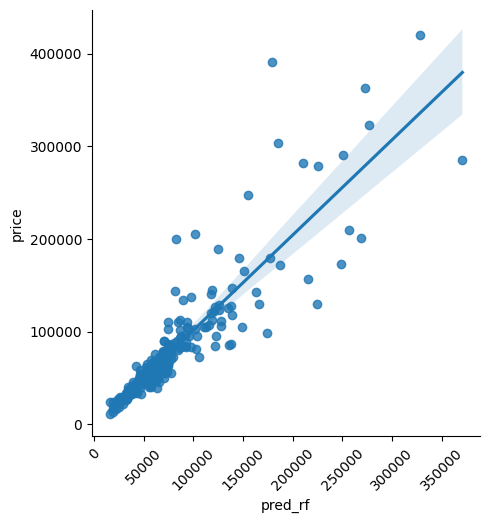

In [26]:
sns.lmplot(yts, x='pred_rf', y='price')
plt.xticks(rotation = 45)

# XGBRegressor

In [27]:
model_xgb=XGBRegressor(random_state=42)

In [ ]:
# Fitting and prediction|Обучение и предсказание
model_xgb.fit(xtr.to_numpy(), ytr)

yts['pred_xgb']=model_xgb.predict(xts.to_numpy())
mae_xgb, mse_xgb = int(mean_absolute_error(yts[['pred_xgb']], yts[['price']])), int(mean_squared_error(yts[['pred_xgb']], yts[['price']]))
r2_xgb = r2_score(yts[['pred_xgb']], yts[['price']])
print(f'MAE:{mae_xgb}, MSE:{mse_xgb}, R2:{r2_xgb}')

## R2 for test -- 0.76, for cross-validation -- 0.725 
## Коэффициент детерминации на тесте --  0.76, на кросс-валидации --  0.725,

C:\Users\cours\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000.]),
 [Text(-50000.0, 0, '−50000'),
  Text(0.0, 0, '0'),
  Text(50000.0, 0, '50000'),
  Text(100000.0, 0, '100000'),
  Text(150000.0, 0, '150000'),
  Text(200000.0, 0, '200000'),
  Text(250000.0, 0, '250000'),
  Text(300000.0, 0, '300000'),
  Text(350000.0, 0, '350000'),
  Text(400000.0, 0, '400000')])

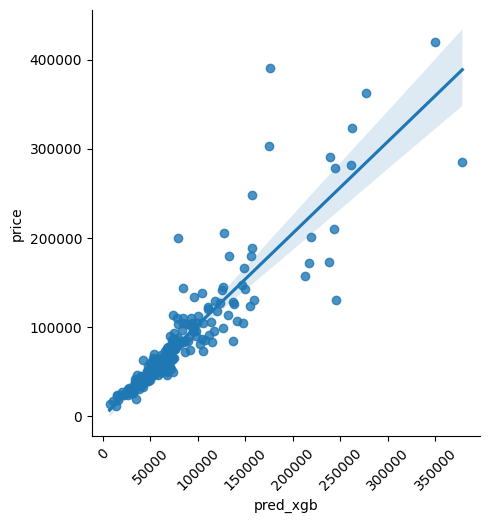

In [29]:
sns.lmplot(yts, x='pred_xgb', y='price')
plt.xticks(rotation=45)

In [30]:
# Getting cat-features back in start condition|Возвращение категориальных к изначальному состоянию
df_2 = pd.concat([df_num, df.select_dtypes(include='object')], axis=1) 

In [31]:
# Cross-validation| Кросс-валидация
cvs_xgb = cross_val_score(model_xgb, X.to_numpy(), y, cv=5)
cvs_xgb, np.mean(cvs_xgb)

(array([0.66368793, 0.86177915, 0.7350261 , 0.73857735, 0.62432254]),
 0.7246786110048151)

## Инициализация модели с определением категориальных колонок

In [32]:
model_cb = CatBoostRegressor(cat_features=list(range(len(df_num.columns), len(df_2.columns))), verbose=500, random_state=42)

In [33]:
X = df_2

In [34]:
xtr, xts, ytr, yts = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

# CatBoostRegressor

In [ ]:
# Fitting and prediction|Обучение и предсказание

model_cb.fit(xtr, ytr)
yts['pred_cb'] = model_cb.predict(xts)
mae_cb, mse_cb = int(mean_absolute_error(yts[['pred_cb']], yts[['price']])), int(mean_squared_error(yts[['pred_cb']], yts[['price']]))
r2_cb = r2_score(yts[['pred_cb']], yts[['price']])
print(f'MAE:{mae_cb}, MSE:{mse_cb}, R2:{r2_cb}')

In [36]:
# Cross-validation| Кросс-валидация
cvs_cb = cross_val_score(model_cb, X, y, cv=5)
cvs_cb, np.mean(cvs_cb)

Learning rate set to 0.038821
0:	learn: 62638.6727095	total: 68.7ms	remaining: 1m 8s
500:	learn: 11614.1699616	total: 43.4s	remaining: 43.2s
999:	learn: 7594.3966699	total: 1m 27s	remaining: 0us
Learning rate set to 0.038821
0:	learn: 59520.9624237	total: 70.7ms	remaining: 1m 10s
500:	learn: 12323.3078869	total: 43.1s	remaining: 42.9s
999:	learn: 7936.4527010	total: 1m 24s	remaining: 0us
Learning rate set to 0.038821
0:	learn: 60621.0047339	total: 65.4ms	remaining: 1m 5s
500:	learn: 11243.7679460	total: 42.4s	remaining: 42.3s
999:	learn: 7316.9933800	total: 1m 24s	remaining: 0us
Learning rate set to 0.038829
0:	learn: 55308.0097200	total: 70.6ms	remaining: 1m 10s
500:	learn: 11089.3565924	total: 42.2s	remaining: 42.1s
999:	learn: 6851.7100094	total: 1m 24s	remaining: 0us
Learning rate set to 0.038829
0:	learn: 59154.5736176	total: 86.2ms	remaining: 1m 26s
500:	learn: 10684.3282464	total: 44.5s	remaining: 44.3s
999:	learn: 7137.8982312	total: 1m 27s	remaining: 0us


(array([0.74670534, 0.77119606, 0.70698911, 0.79568688, 0.78377158]),
 0.7608697952043563)

## R2 for test -- 0.8, for cross-validation -- 0.76 
## Коэффициент детерминации на тесте --  0.8, на кросс-валидации --  0.76,

C:\Users\cours\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000.]),
 [Text(-50000.0, 0, '−50000'),
  Text(0.0, 0, '0'),
  Text(50000.0, 0, '50000'),
  Text(100000.0, 0, '100000'),
  Text(150000.0, 0, '150000'),
  Text(200000.0, 0, '200000'),
  Text(250000.0, 0, '250000'),
  Text(300000.0, 0, '300000'),
  Text(350000.0, 0, '350000'),
  Text(400000.0, 0, '400000')])

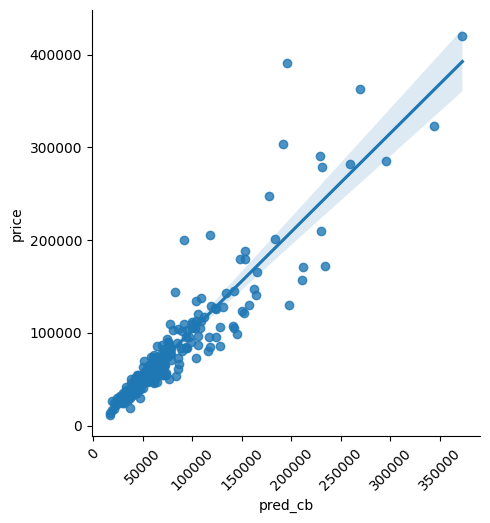

In [37]:
sns.lmplot(yts, x='pred_cb', y='price')
plt.xticks(rotation=45)